In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Define the file path
file_path = r"G:\Shared drives\San Diego Taxpayers Educational Foundation\Data Team\Campaign Finance & Political Activity\Wage Datasets\K12 wage data\fullteach.csv"
# Load the dataset
k12 = pd.read_csv(file_path)

# Display the first few rows of the dataset to confirm it's loaded
k12.head()


,name,position,pay_and_benefits,year,dist,enrollment,pay_and_benefits_adjusted
0,A RICE-HEALY,SPEECH /LANGUAGE PATHOLOGIST,99517.0,2014,SAN DIEGO UNIFIED,130303,96514.708781
1,A RICE-HEALY,SPEECH /LANGUAGE PATHOLOGIST,114043.0,2016,SAN DIEGO UNIFIED,129380,109095.103651
2,A RICE-HEALY,SPEECH /LANGUAGE PATHOLOGIST,117526.0,2017,SAN DIEGO UNIFIED,128040,110081.855597
3,A RICE-HEALY,SPEECH /LANGUAGE PATHOLOGIST,115337.0,2018,SAN DIEGO UNIFIED,126400,105455.774542
4,A RICE-HEALY,SPEECH /LANGUAGE PATHOLOGIST,115337.0,2019,SAN DIEGO UNIFIED,124105,103578.948271


In [3]:
# Filter rows where 'position' contains 'Teacher' and 'Status' is 'FT'
teacher_ft_jobs = k12[(k12['position'].str.contains('Teacher', case=False, na=False))]

# Get unique values of 'position' from the filtered rows
unique_teacher_ft_jobs = teacher_ft_jobs['position'].unique()

# Print the list of unique job titles
print(unique_teacher_ft_jobs)

['TEACHER-DEAF ED' 'TEACHER' 'REGULAR TEACHER' ... 'RESOURCE TEACHER,RDM'
 'TEACHER BLK MT ACADEMY' 'OTAY TEACHER']


In [5]:
#Filter for FT jobs and teachers from unique_teacher_ft_jobs
fil_k12 = k12[(k12['position'].isin(unique_teacher_ft_jobs))]

In [7]:
# Reset the index to avoid issues with duplicate labels
fil_k12 = fil_k12.reset_index(drop=True)

# Create the 'switched' column that reflects whether the teacher switched districts even once
fil_k12['switched'] = fil_k12.groupby('name')['dist'].transform(lambda x: x.nunique() > 1)

# Show the first few rows of the updated dataset
fil_k12.head()


,name,position,pay_and_benefits,year,dist,enrollment,pay_and_benefits_adjusted,switched
0,"AABERG, SUSAN",TEACHER-DEAF ED,94992.00,2013,SAN DIEGO UNIFIED,130270,93620.682134,False
1,AAMNA AHMAD KAMIL,TEACHER,67045.93,2012,GROSSMONT UNION HIGH,23675,67045.930000,False
2,AAMNA AHMAD KAMIL,TEACHER,70615.32,2013,GROSSMONT UNION HIGH,22965,69595.907314,False
3,AAMNA AHMAD KAMIL,TEACHER,77772.07,2014,GROSSMONT UNION HIGH,22555,75425.793456,False
4,AAMNA AHMAD KAMIL,TEACHER,78886.21,2015,GROSSMONT UNION HIGH,22220,76415.617862,False


In [50]:
# Ensure the data is sorted by 'name' and 'year' in ascending order
diff_k12_sorted = fil_k12.sort_values(by=['name', 'year'])

# Group by 'name' and calculate the difference between the most recent and first 'pay_and_benefits_adjusted'
pay_diff = diff_k12_sorted.groupby('name').agg(
    first_year_pay=('pay_and_benefits_adjusted', 'first'),
    recent_year_pay=('pay_and_benefits_adjusted', 'last')
)

# Calculate the pay difference (most recent - first)
pay_diff['pay_difference'] = pay_diff['recent_year_pay'] - pay_diff['first_year_pay']

# Merge the calculated difference back to the original dataset
diff_k12 = diff_k12_sorted.merge(pay_diff[['pay_difference']], on='name')

# Drop the original 'pay_difference' column (assuming it's the old one)
diff_k12 = diff_k12.drop(columns=['pay_difference_x'])

# Rename the newly calculated 'pay_difference_y' column
diff_k12 = diff_k12.rename(columns={'pay_difference_y': 'pay_difference'})

In [53]:
# Separate the data into two groups based on the 'switched' column
true_group = diff_k12[diff_k12['switched'] == True]['pay_difference']
false_group = diff_k12[diff_k12['switched'] == False]['pay_difference']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(true_group, false_group)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 29.88295266477598
P-value: 9.299148384400012e-196


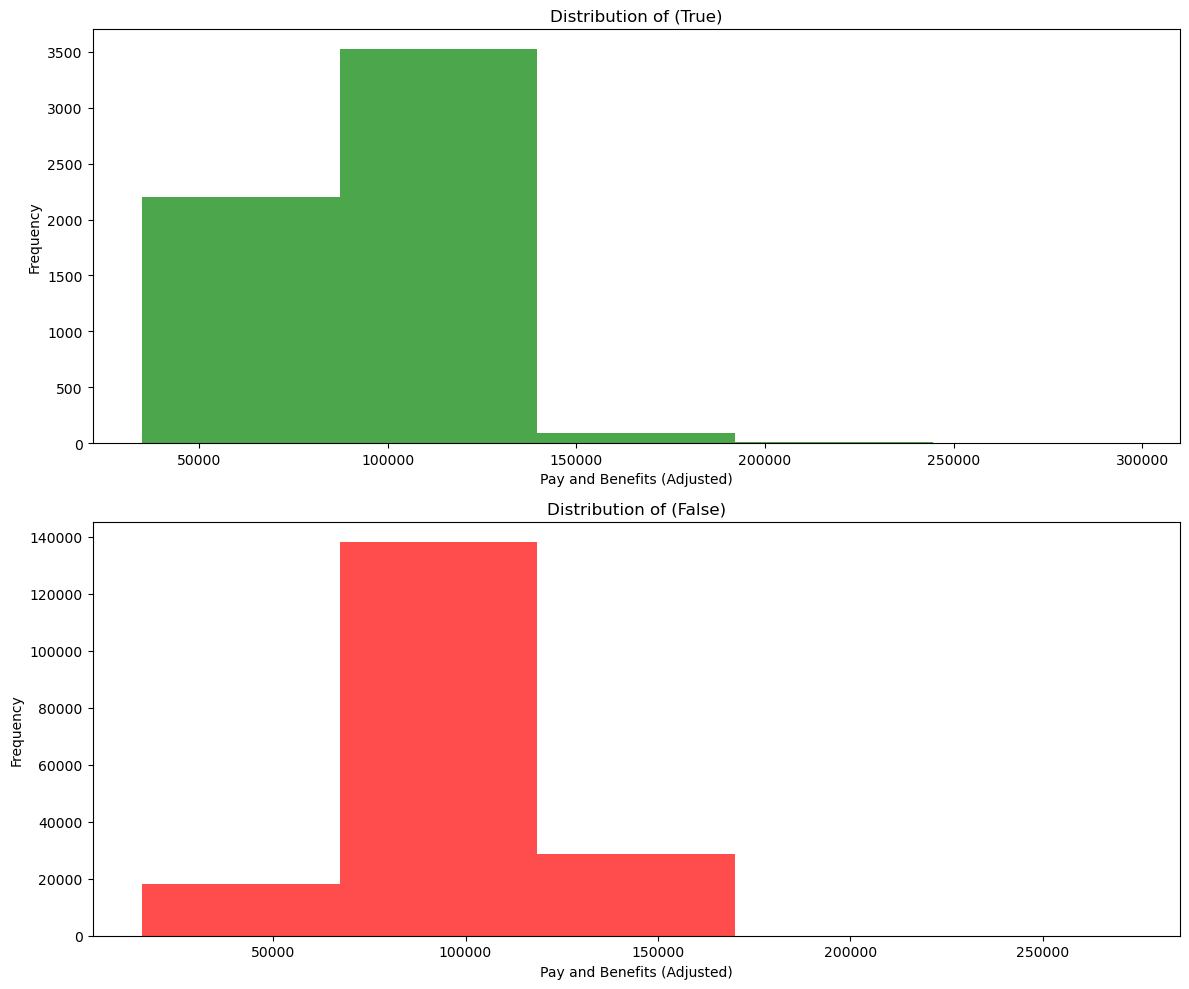

In [55]:
# Creating two separate histograms for True and False pay_and_benefits_adjusted

plt.figure(figsize=(12, 10))

# Histogram for 'True' (High Pay)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(diff_k12[diff_k12['switched'] == True]['pay_and_benefits_adjusted'], bins=5, color='green', alpha=0.7)
plt.title('Distribution of (True)')
plt.xlabel('Pay and Benefits (Adjusted)')
plt.ylabel('Frequency')

# Histogram for 'False' (Low Pay)
plt.subplot(2, 1, 2)  # 2nd plot
plt.hist(diff_k12[diff_k12['switched'] == False]['pay_and_benefits_adjusted'], bins=5, color='red', alpha=0.7)
plt.title('Distribution of (False)')
plt.xlabel('Pay and Benefits (Adjusted)')
plt.ylabel('Frequency')

plt.tight_layout()

# Display the separated histograms
plt.show()

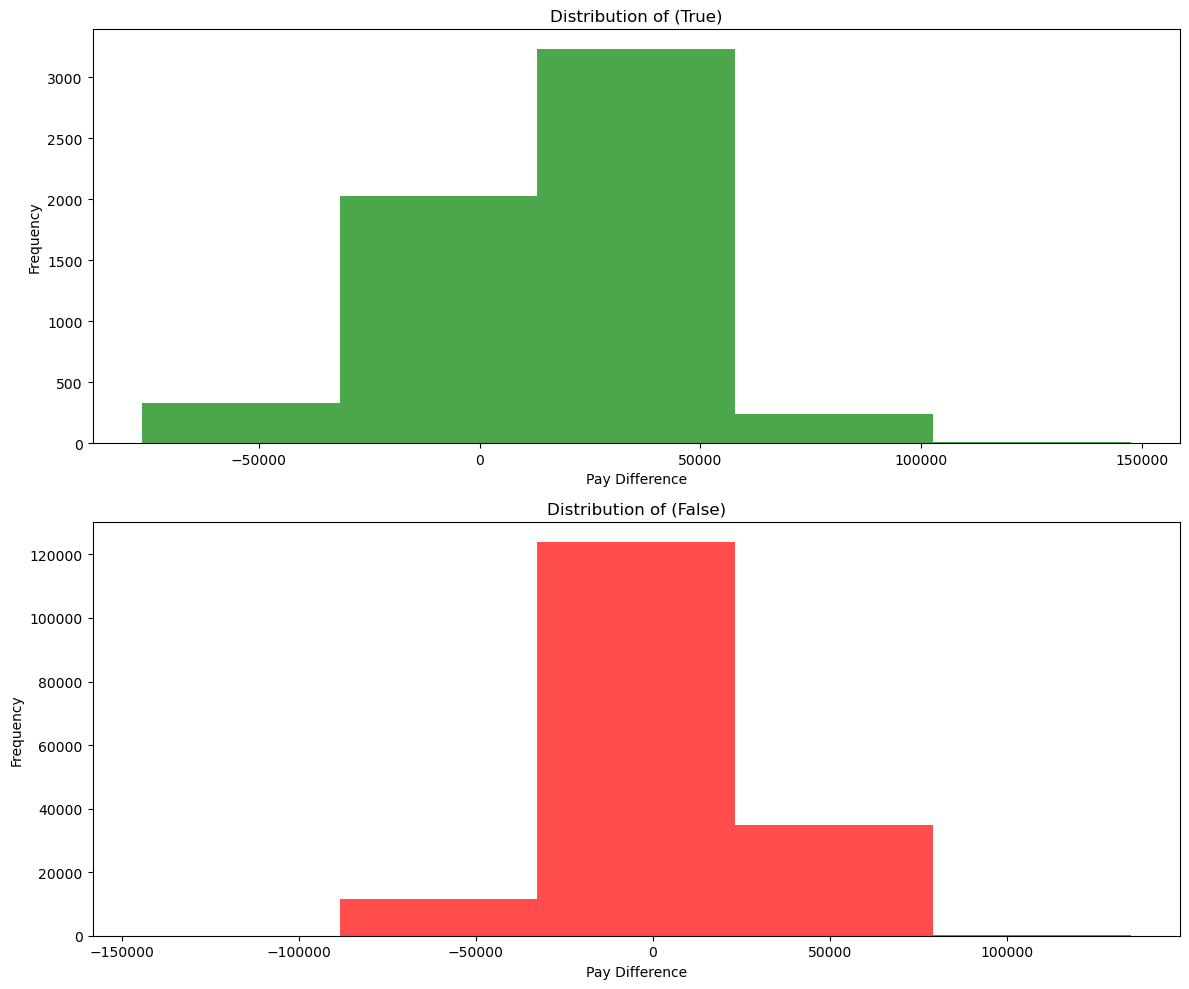

In [33]:
# Creating two separate histograms for True and False pay_difference

plt.figure(figsize=(12, 10))

# Histogram for 'True' (High Pay)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(diff_k12[diff_k12['switched'] == True]['pay_difference'], bins=5, color='green', alpha=0.7)
plt.title('Distribution of (True)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

# Histogram for 'False' (Low Pay)
plt.subplot(2, 1, 2)  # 2nd plot
plt.hist(diff_k12[diff_k12['switched'] == False]['pay_difference'], bins=5, color='red', alpha=0.7)
plt.title('Distribution of (False)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

plt.tight_layout()

# Display the separated histograms
plt.show()

In [57]:
##Looking at negetive values
# Creating a new dataset with entries where 'pay_difference' is less than 0
neg_diff_k12 = diff_k12[diff_k12['pay_difference'] < 0]

# Displaying the first few rows of the filtered dataset (optional)
print(neg_diff_k12.head())

            name                      position  pay_and_benefits  year  \
75  AARON GRABLE  TEACHER HOURLY TEACHING RATE         116596.00  2016   
76  AARON GRABLE                   ROP TEACHER         119925.32  2017   
77  AARON GRABLE                 TEACHER - CTE         116733.01  2018   
78  AARON GRABLE                 TEACHER - CTE         118007.00  2019   
79  AARON GRABLE                 TEACHER - CTE         126130.00  2020   

                 dist  enrollment  pay_and_benefits_adjusted  switched  \
75  OCEANSIDE UNIFIED       21024              111537.338594     False   
76  OCEANSIDE UNIFIED       20629              112329.201697     False   
77  OCEANSIDE UNIFIED       20459              106732.184678     False   
78  OCEANSIDE UNIFIED       19749              105976.754628     False   
79  OCEANSIDE UNIFIED       21113              111891.268996     False   

    pay_difference  
75     -4796.97724  
76     -4796.97724  
77     -4796.97724  
78     -4796.97724  
79   

In [60]:
# Calculate the average count of negative 'pay_difference' values for 'switched' being True and False
negative_pay_diff = diff_k12[diff_k12['pay_difference'] < 0]

# Group by 'switched' and calculate the count of negative values
negative_pay_diff_counts = negative_pay_diff.groupby('switched').size()

# Calculate the average count for True and False 'switched' values
negative_pay_diff_avg = negative_pay_diff_counts / diff_k12['switched'].value_counts()

negative_pay_diff_avg

switched
False    0.214292
True     0.195581
dtype: float64

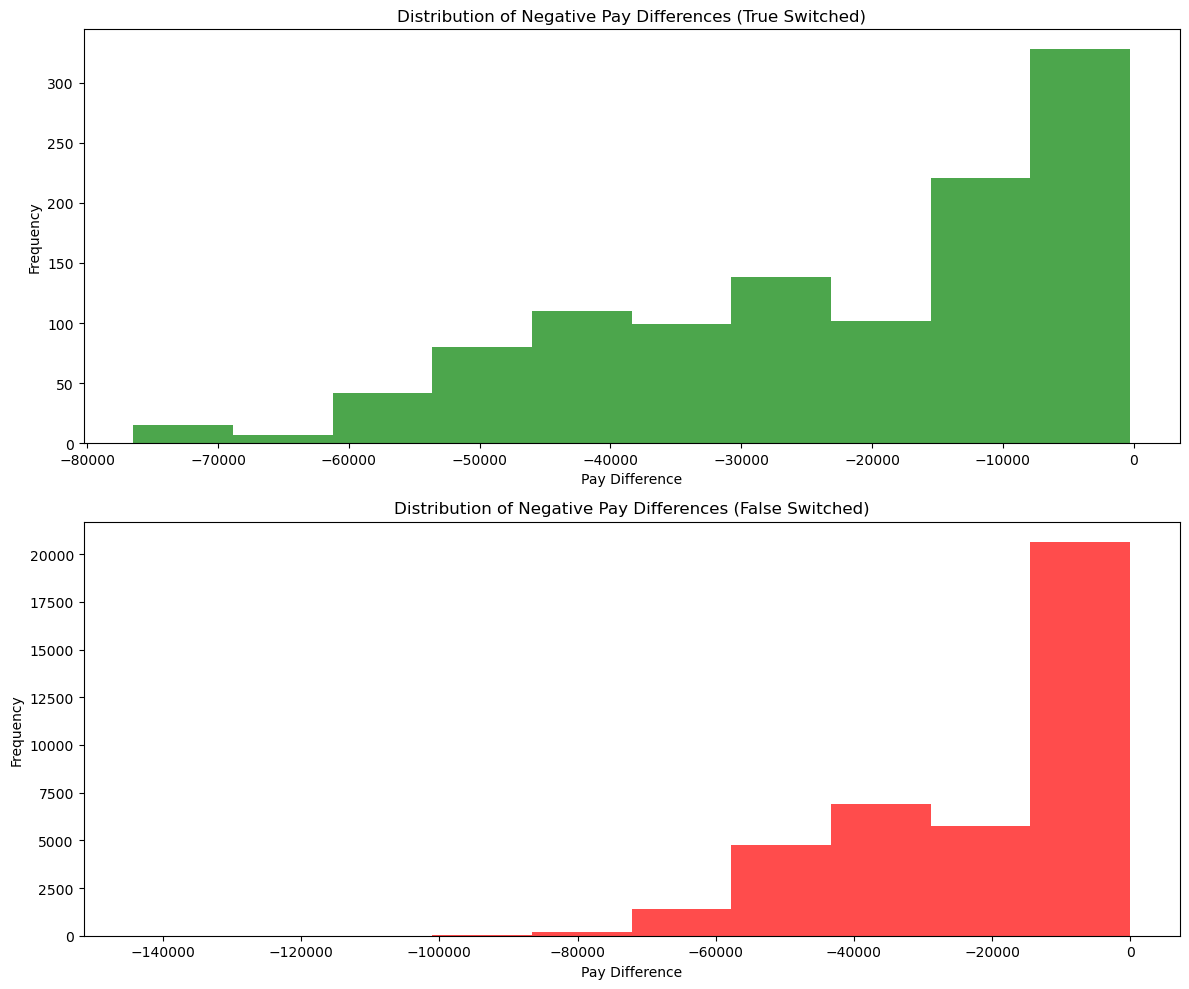

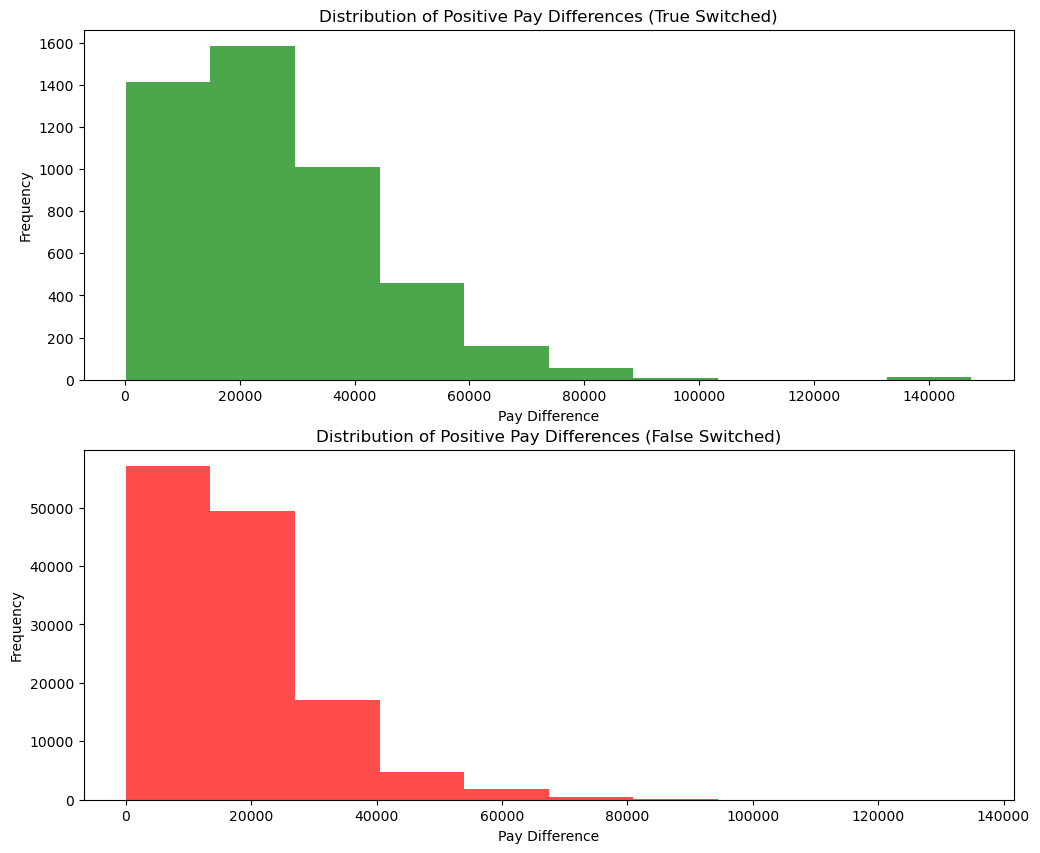

In [66]:
# Filter the dataset for negative pay differences
negative_pay_diff = diff_k12[diff_k12['pay_difference'] < 0]

# Plotting two histograms, one for 'True' and one for 'False', to show the distribution of negative pay differences
plt.figure(figsize=(12, 10))

# Histogram for 'True' (Switched)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(negative_pay_diff[negative_pay_diff['switched'] == True]['pay_difference'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of Negative Pay Differences (True Switched)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

# Histogram for 'False' (Switched)
plt.subplot(2, 1, 2)  # 2nd plot
plt.hist(negative_pay_diff[negative_pay_diff['switched'] == False]['pay_difference'], bins=10, color='red', alpha=0.7)
plt.title('Distribution of Negative Pay Differences (False Switched)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

plt.tight_layout()

# Filter the dataset for positive pay differences
positive_pay_diff = diff_k12[diff_k12['pay_difference'] > 0]

# Plotting two histograms, one for 'True' and one for 'False', to show the distribution of positive pay differences
plt.figure(figsize=(12, 10))

# Histogram for 'True' (Switched)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(positive_pay_diff[positive_pay_diff['switched'] == True]['pay_difference'], bins=10, color='green', alpha=0.7)
plt.title('Distribution of Positive Pay Differences (True Switched)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

# Histogram for 'False' (Switched)
plt.subplot(2, 1, 2)  # 2nd plot
plt.hist(positive_pay_diff[positive_pay_diff['switched'] == False]['pay_difference'], bins=10, color='red', alpha=0.7)
plt.title('Distribution of Positive Pay Differences (False Switched)')
plt.xlabel('Pay Difference')
plt.ylabel('Frequency')

# Show the histograms
plt.show()

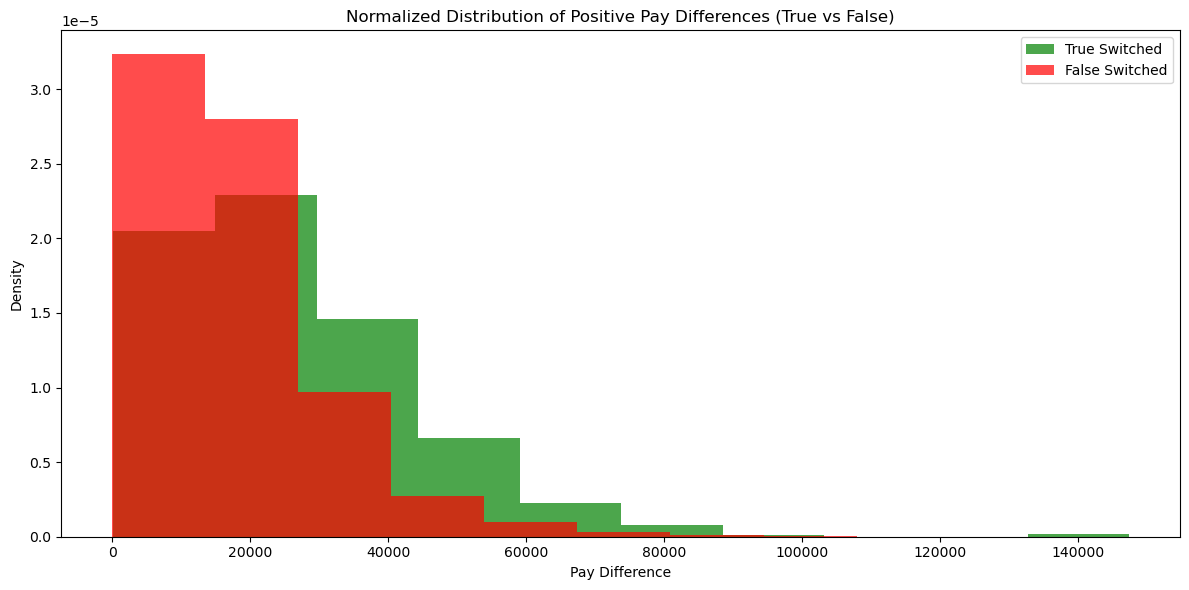

In [68]:
# Plotting two histograms, normalized for comparison
plt.figure(figsize=(12, 6))

# Histogram for 'True' (Switched), normalized
plt.hist(positive_pay_diff[positive_pay_diff['switched'] == True]['pay_difference'], bins=10, color='green', alpha=0.7, density=True, label='True Switched')

# Histogram for 'False' (Switched), normalized
plt.hist(positive_pay_diff[positive_pay_diff['switched'] == False]['pay_difference'], bins=10, color='red', alpha=0.7, density=True, label='False Switched')

plt.title('Normalized Distribution of Positive Pay Differences (True vs False)')
plt.xlabel('Pay Difference')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [74]:
# Create a new column 'switch' where 0 is for False and 1 is for True in the 'switched' column
diff_k12['switch'] = diff_k12['switched'].astype(int)

In [80]:
# Create a new column 'p/n' where 0 is for negative pay_difference and 1 is for positive pay_difference
diff_k12['p/n'] = (diff_k12['pay_difference'] > 0).astype(int)

In [82]:
# Independent variables: 'switch' and 'year'
X = diff_k12[['switch', 'year']]
X = sm.add_constant(X)  # Adds a constant (intercept)

# Dependent variable: 'p/n' (binary: 0 for negative, 1 for positive)
y = diff_k12['p/n']

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Print the model summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.601364
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    p/n   No. Observations:               190998
Model:                          Logit   Df Residuals:                   190995
Method:                           MLE   Df Model:                            2
Date:                Wed, 02 Oct 2024   Pseudo R-squ.:                0.001414
Time:                        13:19:45   Log-Likelihood:            -1.1486e+05
converged:                       True   LL-Null:                   -1.1502e+05
Covariance Type:            nonrobust   LLR p-value:                 2.400e-71
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.1328      3.332     -6.343      0.000     -27.662     -14.603
switch         0.5199      0.